In [1]:
import sys
sys.path.append('/home/khoa-ys/Projects/auto_inspection/research')
from utils.data_analysis import *
from utils.data_handling import *

import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from pathlib import Path
from tqdm import tqdm

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

In [2]:
path = Path('/home/khoa-ys/Projects/auto_inspection/research/data')
im_path = path/'images'
labels_path = path/'labels.csv'

In [3]:
image_list = list(im_path.iterdir())
print(len(image_list))
image_list[:10]

2624


[PosixPath('/home/khoa-ys/Projects/auto_inspection/research/data/images/cell2346.png'),
 PosixPath('/home/khoa-ys/Projects/auto_inspection/research/data/images/cell2391.png'),
 PosixPath('/home/khoa-ys/Projects/auto_inspection/research/data/images/cell0837.png'),
 PosixPath('/home/khoa-ys/Projects/auto_inspection/research/data/images/cell0625.png'),
 PosixPath('/home/khoa-ys/Projects/auto_inspection/research/data/images/cell0682.png'),
 PosixPath('/home/khoa-ys/Projects/auto_inspection/research/data/images/cell2356.png'),
 PosixPath('/home/khoa-ys/Projects/auto_inspection/research/data/images/cell2262.png'),
 PosixPath('/home/khoa-ys/Projects/auto_inspection/research/data/images/cell2322.png'),
 PosixPath('/home/khoa-ys/Projects/auto_inspection/research/data/images/cell2541.png'),
 PosixPath('/home/khoa-ys/Projects/auto_inspection/research/data/images/cell0920.png')]

### Load images' metadata

In [4]:
metadata = pd.read_csv(labels_path, delim_whitespace=True, header=None)
metadata.columns = ['im_path', 'quality', 'cell type']
metadata.quality = metadata["quality"].map(lambda value: 'bad' if value > 0 else 'good')
metadata['class'] = metadata[['cell type', 'quality']].agg(' '.join, axis=1)
metadata

,im_path,quality,cell type,class
0,images/cell0001.png,bad,mono,mono bad
1,images/cell0002.png,bad,mono,mono bad
2,images/cell0003.png,bad,mono,mono bad
3,images/cell0004.png,good,mono,mono good
4,images/cell0005.png,bad,mono,mono bad
...,...,...,...,...
2619,images/cell2620.png,good,poly,poly good
2620,images/cell2621.png,good,poly,poly good
2621,images/cell2622.png,good,poly,poly good
2622,images/cell2623.png,good,poly,poly good


## Image parameters

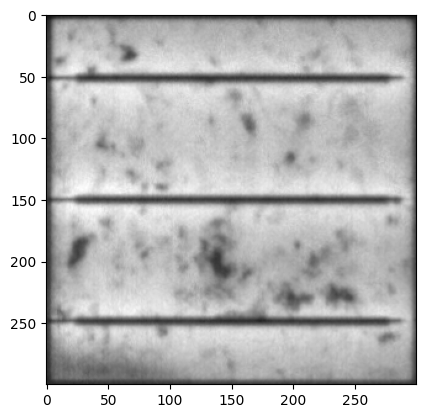

In [5]:
images = load_images_from_directory(str(im_path), '*.png')
plt.imshow(images[0], cmap='gray')

In [6]:
metadata['means'] = compute_means_from_images(images)
metadata['medians'] = compute_median_from_images(images)
metadata['maxs'] = compute_max_from_images(images)
metadata['mins'] = compute_min_from_images(images)
metadata['modes'] = compute_mode_from_images(images)
metadata

/home/khoa-ys/Projects/auto_inspection/research/utils/data_analysis.py:46: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return stats.mode(image.flatten(), axis=0)[0]


,im_path,quality,cell type,class,means,medians,maxs,mins,modes
0,images/cell0001.png,bad,mono,mono bad,163.122078,170.0,210,62,175
1,images/cell0002.png,bad,mono,mono bad,167.312767,172.0,221,71,173
2,images/cell0003.png,bad,mono,mono bad,153.776522,159.0,208,45,168
3,images/cell0004.png,good,mono,mono good,166.015011,173.0,219,73,184
4,images/cell0005.png,bad,mono,mono bad,129.489733,137.0,168,33,138
...,...,...,...,...,...,...,...,...,...
2619,images/cell2620.png,good,poly,poly good,167.802400,174.0,193,83,178
2620,images/cell2621.png,good,poly,poly good,175.762022,184.0,245,61,202
2621,images/cell2622.png,good,poly,poly good,152.267722,157.0,178,77,156
2622,images/cell2623.png,good,poly,poly good,147.383544,157.0,209,49,165


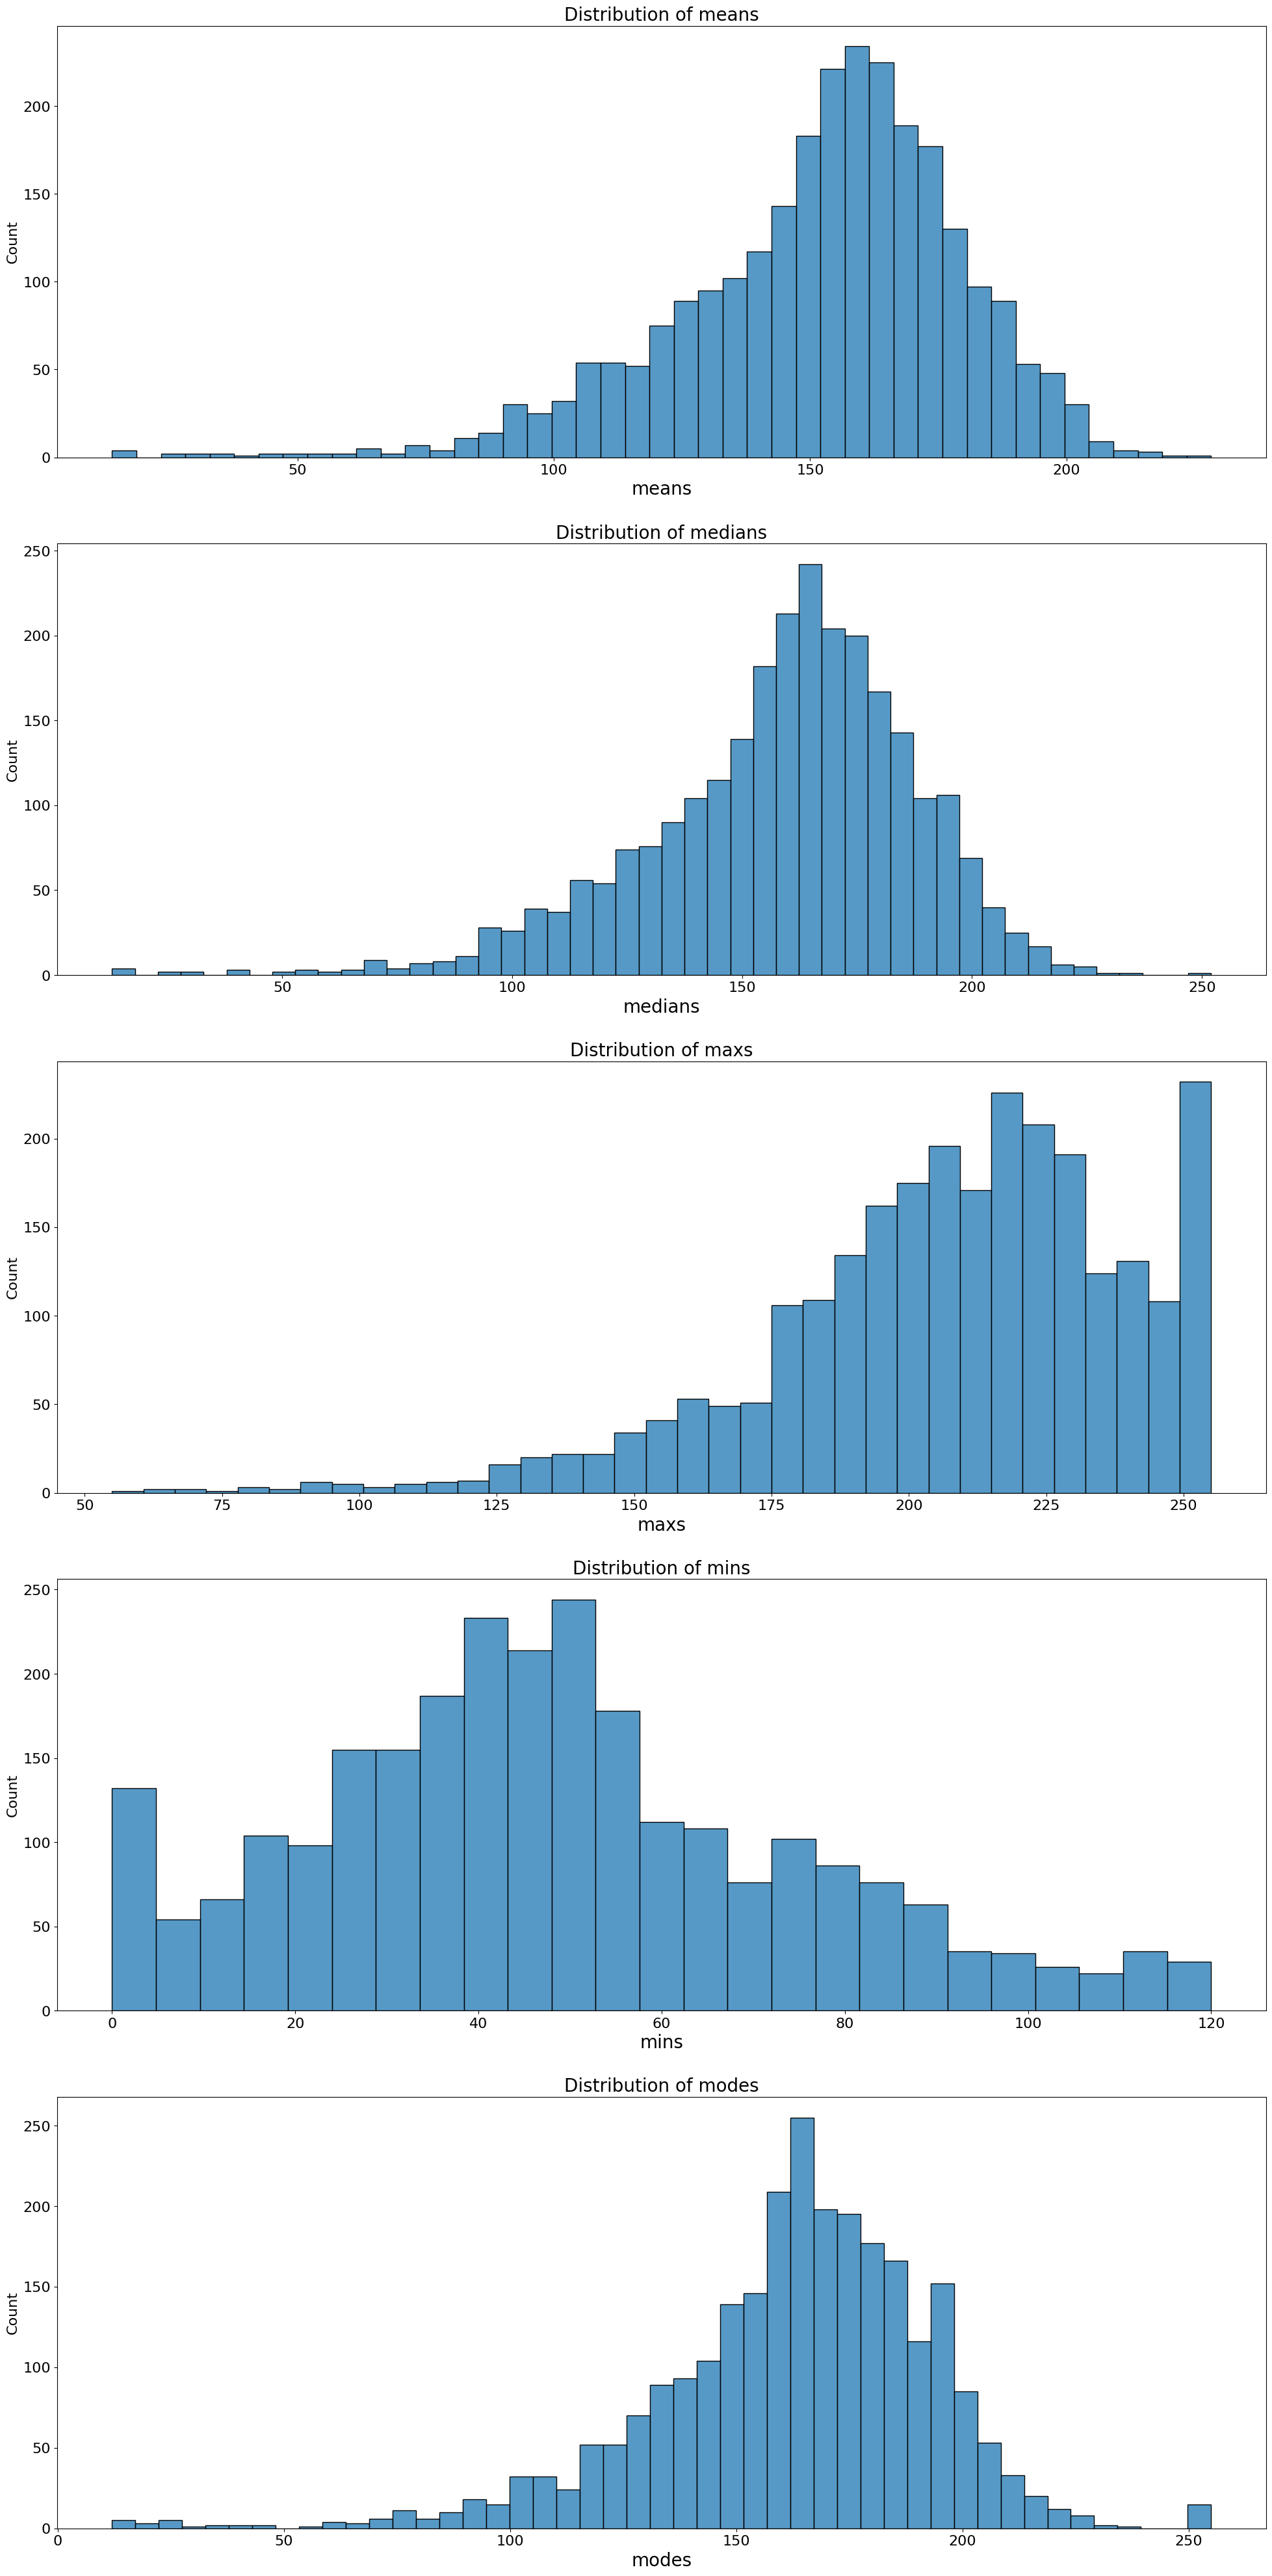

In [7]:
fig, ax = plt.subplots(5, 1, figsize=(24, 50))
titles = ['means', 'medians', 'maxs', 'mins', 'modes']
for i in range(5):
    ax[i].set_title("Distribution of " + titles[i], fontsize=20)
    ax[i].set_xlabel(titles[i],fontsize=20)
    ax[i].set_ylabel("Count", fontsize=16)
    ax[i].tick_params(labelsize=16)
    sns.histplot(metadata[titles[i]], ax=ax[i])

## Image embedding with PCA

In [8]:
flatten_images = np.array([image.flatten() for image in images])
flatten_images.shape

(2624, 90000)

In [9]:
pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(flatten_images.data)
 
converted_data.shape

(2624, 2)

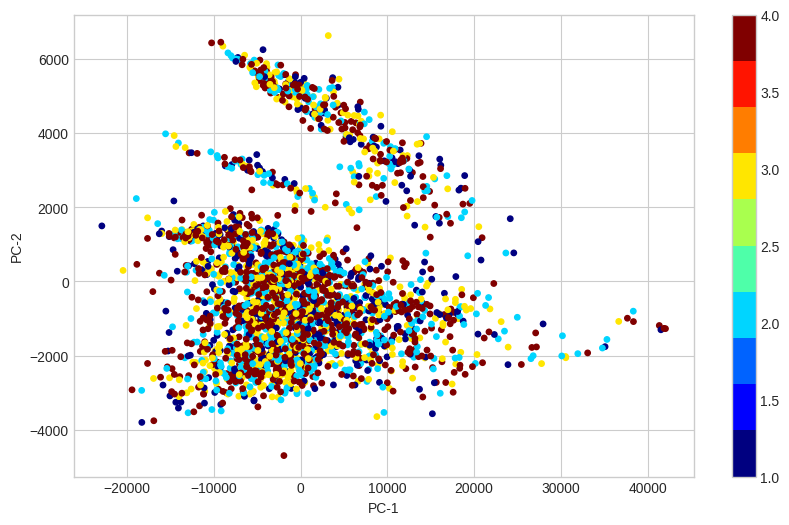

In [10]:
labels = metadata['class'].map({'mono bad': 1, 'mono good': 2, 'poly bad': 3, 'poly good': 4})
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 15,
            cmap = c_map , c = labels)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

## Image embedding with fiftyone

In [11]:
model = foz.load_zoo_model("resnet50-imagenet-torch")
print(model.has_embeddings)

/home/khoa-ys/Projects/auto_inspection/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/khoa-ys/Projects/auto_inspection/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


True


In [12]:
dataset = fo.load_dataset('dataset')
dataset.delete()

In [13]:
dataset = fo.Dataset('dataset')
for im_path in image_list:
    im_name = str('images/' + im_path.name)
    sample = fo.Sample(filepath=str(im_path))
    im_data = metadata[metadata['im_path'] == im_name]
    sample['label'] = fo.Classification(label=im_data['class'].values[0])
    dataset.add_sample(sample)

#dataset = fo.load_dataset('dataset')
dataset.persistent = True
dataset

Name:        dataset
Media type:  image
Num samples: 2624
Persistent:  True
Tags:        []
Sample fields:
    id:       fiftyone.core.fields.ObjectIdField
    filepath: fiftyone.core.fields.StringField
    tags:     fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    label:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)

In [14]:
embeddings = dataset.compute_embeddings(model)
results = fob.compute_visualization(
    dataset,
    embeddings=embeddings,
    num_dims=2,
    brain_key="image_embeddings",
    verbose=True,
    seed=51,
    method='umap'
)

 100% |███████████████| 2624/2624 [22.8s elapsed, 0s remaining, 127.3 samples/s]      
Generating visualization...
UMAP(random_state=51, verbose=True)
Sun Sep 11 10:07:22 2022 Construct fuzzy simplicial set
Sun Sep 11 10:07:27 2022 Finding Nearest Neighbors
Sun Sep 11 10:07:28 2022 Finished Nearest Neighbor Search
Sun Sep 11 10:07:30 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Sep 11 10:07:33 2022 Finished embedding



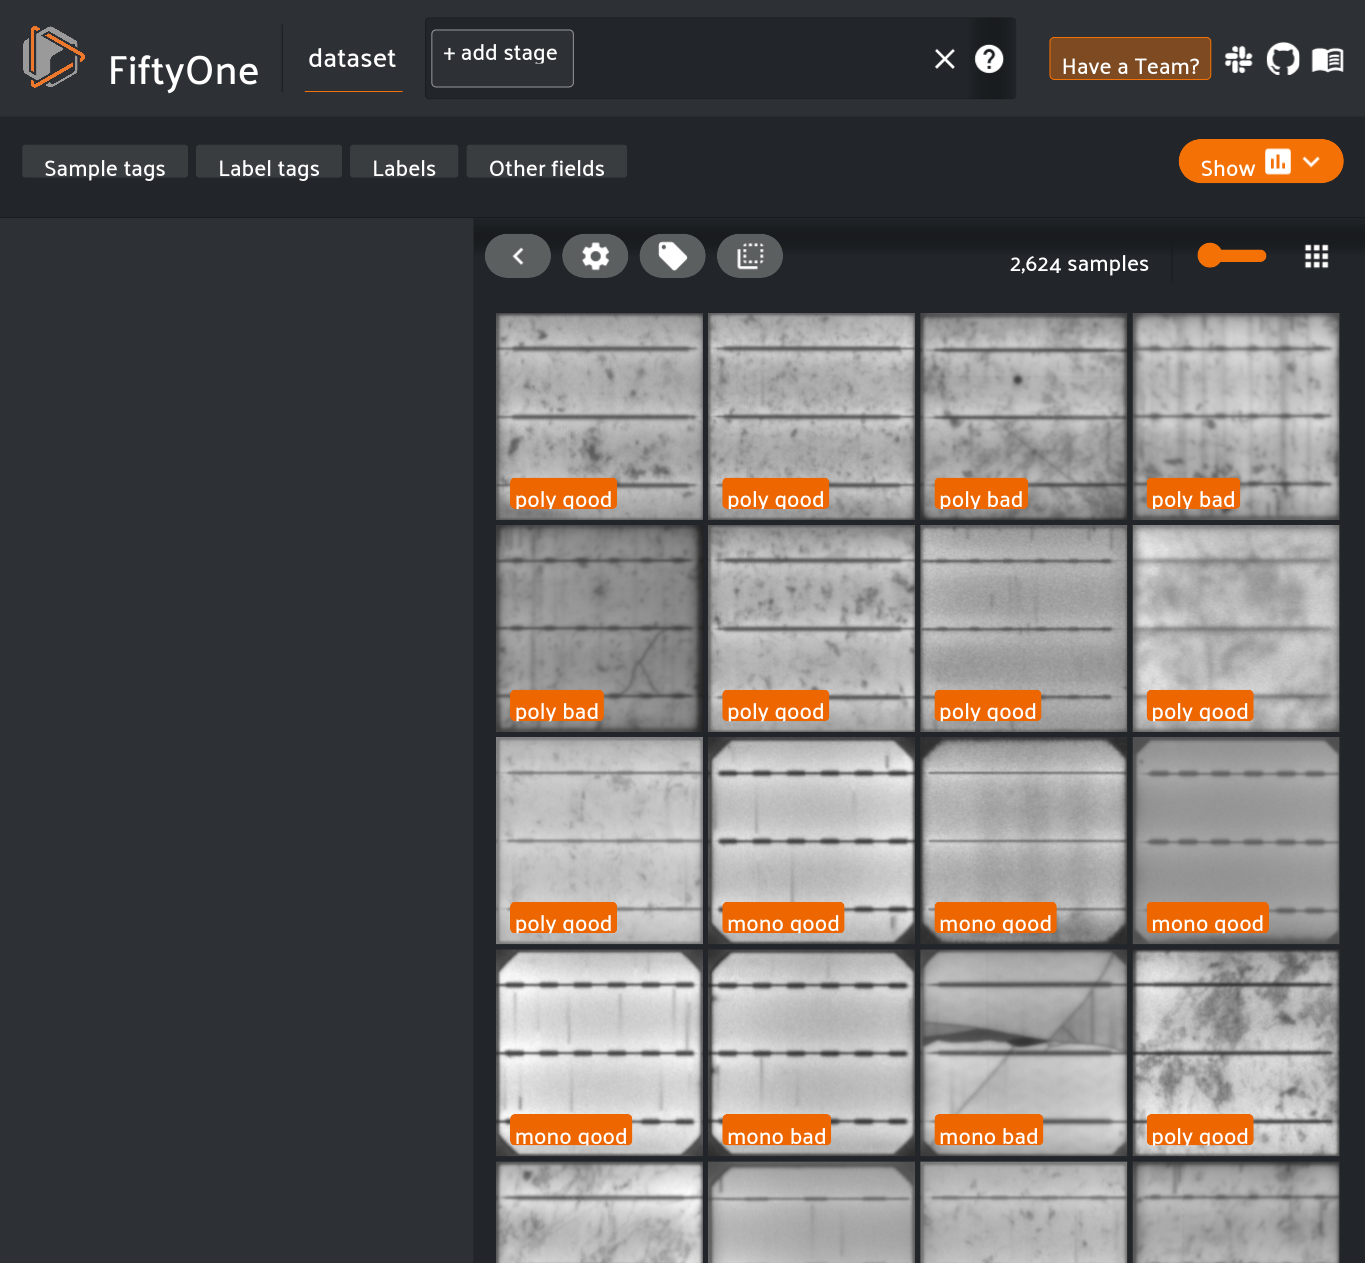

In [15]:
session = fo.launch_app(dataset)

In [16]:
labels = metadata['class']
plot = results.visualize(labels=labels)
session.plots.attach(plot)
plot.show(height=720)

FigureWidget({
    'data': [{'customdata': array(['631d890e2f173db3f72d0c96', '631d890e2f173db3f72d0c99',
    …

### Embedding without LCB and MCB

In [17]:
metadata = pd.read_csv(labels_path, delim_whitespace=True, header=None)
metadata.columns = ['im_path', 'quality', 'panel type']
filtered_images = metadata[(metadata['quality'] > 0) & (metadata['quality'] < 1)]['im_path']
metadata = metadata[(metadata['quality'] == 0) | (metadata['quality'] == 1)].reset_index(drop=True)
metadata.quality = metadata["quality"].map(lambda value: 'bad' if value == 1 else 'good')
metadata['class'] = metadata[['panel type', 'quality']].agg(' '.join, axis=1)
metadata

,im_path,quality,panel type,class
0,images/cell0001.png,bad,mono,mono bad
1,images/cell0002.png,bad,mono,mono bad
2,images/cell0003.png,bad,mono,mono bad
3,images/cell0004.png,good,mono,mono good
4,images/cell0005.png,bad,mono,mono bad
...,...,...,...,...
2218,images/cell2620.png,good,poly,poly good
2219,images/cell2621.png,good,poly,poly good
2220,images/cell2622.png,good,poly,poly good
2221,images/cell2623.png,good,poly,poly good


In [18]:
dataset = fo.load_dataset('filtered')
dataset.delete()

In [19]:
dataset = fo.Dataset('filtered')
for im_path in image_list:
    im_name = str('images/' + im_path.name)
    if im_name not in list(filtered_images):
        sample = fo.Sample(filepath=str(im_path))
        im_data = metadata[metadata['im_path'] == im_name]
        sample['label'] = fo.Classification(label=im_data['class'].values[0])
        dataset.add_sample(sample)

#dataset = fo.load_dataset('dataset')
dataset.persistent = True
dataset

Name:        filtered
Media type:  image
Num samples: 2223
Persistent:  True
Tags:        []
Sample fields:
    id:       fiftyone.core.fields.ObjectIdField
    filepath: fiftyone.core.fields.StringField
    tags:     fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    label:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)

In [20]:
embeddings = dataset.compute_embeddings(model)
results = fob.compute_visualization(
    dataset,
    embeddings=embeddings,
    num_dims=2,
    brain_key="image_embeddings",
    verbose=True,
    seed=51,
    method='umap'
)

 100% |███████████████| 2223/2223 [32.0s elapsed, 0s remaining, 75.4 samples/s]      
Generating visualization...
UMAP(random_state=51, verbose=True)
Sun Sep 11 10:08:11 2022 Construct fuzzy simplicial set
Sun Sep 11 10:08:13 2022 Finding Nearest Neighbors
Sun Sep 11 10:08:13 2022 Finished Nearest Neighbor Search
Sun Sep 11 10:08:13 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Sep 11 10:08:16 2022 Finished embedding


In [21]:
session = fo.launch_app(dataset)

In [22]:
labels = metadata['class']
plot = results.visualize(labels=labels)
session.plots.attach(plot)
plot.show(height=720)

FigureWidget({
    'data': [{'customdata': array(['631d89382f173db3f72d3599', '631d89382f173db3f72d359c',
    …


Could not connect session, trying again in 10 seconds

